## Cargamos los datos del dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import metnum
# Carquemos el dataset 
df_train = pd.read_csv("../data/train.csv")
# Veamos el tamaño
print("Dimensiones: ", df_train.shape)
# Y sus primeras filas 
pd.set_option("display.max.columns", None)
df_train.head(5)

Dimensiones:  (240000, 23)


,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0
2,247984,casa en venta urbi 3 recamaras tonala,descripcion \nla mejor ubicacion residencial e...,Casa,Urbi Tonala,Tonalá,Jalisco,5.0,3.0,2.0,2.0,144.0,166.0,48551.0,NaN,NaN,2015-10-17 00:00:00,0.0,0.0,0.0,0.0,0.0,1200000.0
3,209067,casa sola en toluca zinacantepec con credito i...,casa en privada con caseta de vigilancia casas...,Casa,IGNACIO MANUEL ALTAMIRANO 128,Zinacantepec,Edo. de México,1.0,2.0,1.0,1.0,63.0,67.0,53666.0,19.301890,-99.688015,2012-03-09 00:00:00,0.0,0.0,0.0,1.0,1.0,650000.0
4,185997,paseos del sol,bonito departamento en excelentes condiciones ...,Apartamento,PASEOS DEL SOL,Zapopan,Jalisco,10.0,2.0,1.0,1.0,95.0,95.0,47835.0,NaN,NaN,2016-06-07 00:00:00,0.0,0.0,0.0,0.0,0.0,1150000.0


In [2]:
# Importo las funciones necesarias desde otro archivo nuestro
from extra_scripts import cross_validate, rmse, rmsle

# Experimento 3:
## Habitaciones, apto_familia y cant baños -> metroscubiertos (con y sin segmentacion)

Queremos usar una nueva feature a la que llamamos **apto_familia** la cual indica si la casa esta hecha para estar en familia en base a una busqueda de palabras "familiares" en las descripciones de los inmuebles.

## Arreglos para nuevo feature: apto_familia

In [3]:
# Quiero separar las descripciones
descs = df_train["descripcion"].values
df_descs = []

print(descs.shape)

#limpiemos de los caracteres no necesarios
for string in descs:
    parsed = str(string).replace('\n', ' ')
    parsed = parsed.replace('\r', ' ')
    parsed = parsed.replace("font-family", ' ') #html code
    parsed = parsed.replace('á','a')
    parsed = parsed.replace('é','e')
    parsed = parsed.replace('í','i')
    parsed = parsed.replace('ó','o')
    parsed = parsed.replace('ú','u')
    parsed = parsed.replace('ú','u')
    parsed = parsed.replace('&aacute;','a')
    parsed = parsed.replace('&eacute;','e')
    parsed = parsed.replace('&iacute;','i')
    parsed = parsed.replace('&oacute;','o')
    parsed = parsed.replace('&uacute;','u')
    parsed = parsed.replace('&ntilde;','ñ')
    df_descs.append(parsed)

display(df_descs[31])
df_descs_save = pd.DataFrame(df_descs, columns=["desc"])
df_descs_save.to_csv("Descripciones.csv", columns=["desc"])

(240000,)


'<p>vendo hermosa casa en fraccionamiento lomas de san alfonso por la calera</p>  <p>precio: </p>  <p>t: 196 metros</p>  <p>c: 143 metros</p>  <p>caracteristicas</p>  <p>planta baja: cochera 2 autos, sala, comedor, medio baño, cocina con cocina integral, cuarto de servicio, jardin amplio.</p>  <p>planta alta: recamara principal con baño, 2 recamaras comparten baño.</p>  <p>otros: cisterna, casa club, vigilancia las 24 horas del dia.</p>  <p>informes a grupo ficasa</p>  <p> /  / </p>  <p> / </p>'

In [4]:
#Creo un diccionario de palabras relacionadas a lugares con familia
df_family_words = pd.read_csv("Exp3/apto_familia_dicc.txt", header=None)
#display(df_family_words)
dicc_family = set()
print(df_family_words.values.shape)
# Transformo a un set de palabras
for word in df_family_words[0].values:
    dicc_family.add(word)

(48, 1)


In [5]:
# Creo una lista (ordenada en el sentido que tome el dataset) para guardar un 1 o 0 (familiar o no)
family_list = []
print(df_descs[:1])
for line in df_descs:
    for word in dicc_family:
        res = 0
        if word in line:
            res = 1
            break;
    family_list.append(res)

print(len(family_list))
print(f"Porcentaje de casas aptas para familia: {np.mean(family_list)*100}%")

['depto. interior de 80.15m2, consta de sala comedor cocina equipada, area de lavado, baño completo, recamara principal con closet y baño completo. 2da. recamara con closet.']
240000
Porcentaje de casas aptas para familia: 67.65333333333334%


Esto es **IMPORTANTE**: el porcentaje de casas es bastante alto, casi 2/3 de las casas son aptas para familias

Veamos la distribucion de las palabras en general en las descripciones

In [6]:
# Uno todos las descripciones
dataset = "Start: "
for line in df_descs:
    dataset = dataset + line


In [7]:
from collections import Counter 
# split() returns list of all the words in the string 
split_it = dataset.split() 
# Pass the split_it list to instance of Counter class. 
Counter = Counter(split_it) 
# most_common() produces k frequently encountered 
# input values and their respective counts. 
most_occur = Counter.most_common()
print(most_occur[:50]) 

new_list = []
for word in most_occur[:50]:
    #IMPORTANTE!!! me quedo solo con las palabras de longitud mayor a 3
    #   ya que la mayoria de las mas frecuentes son palabras como "la", "el", "y", "o", etc.
    if len(word[0]) >= 4:
        if "<p>" not in word[0]:
            new_list.append(word)

print(f"\n{new_list}")

[('de', 1043756), ('con', 585816), ('y', 511165), ('en', 390061), ('la', 237732), ('para', 197281), ('a', 163232), ('2', 162197), ('baño', 146930), ('cocina', 116556), ('3', 109517), ('casa', 108943), ('un', 105203), ('el', 102298), ('recamaras', 92997), ('una', 90656), ('cuenta', 87173), ('area', 80616), ('sala', 77925), ('del', 75513), ('dos', 74778), ('cuarto', 71289), ('se', 70315), ('muy', 70267), ('las', 69802), ('comedor,', 67659), ('recamaras,', 66233), ('que', 64478), ('planta', 63652), ('</p><p>', 60983), ('1', 58505), ('al', 57481), ('principal', 55437), ('los', 54900), ('baño,', 47407), (',', 47237), ('sala,', 46393), ('servicio', 46317), ('patio', 46281), ('recamara', 45942), ('m2', 45826), ('excelente', 45567), ('o', 43650), ('baños', 41975), ('estacionamiento', 41374), ('jardin', 41103), ('por', 40442), ('cochera', 39460), ('tiene', 35818), ('comedor', 35805)]

[('para', 197281), ('baño', 146930), ('cocina', 116556), ('casa', 108943), ('recamaras', 92997), ('cuenta', 871

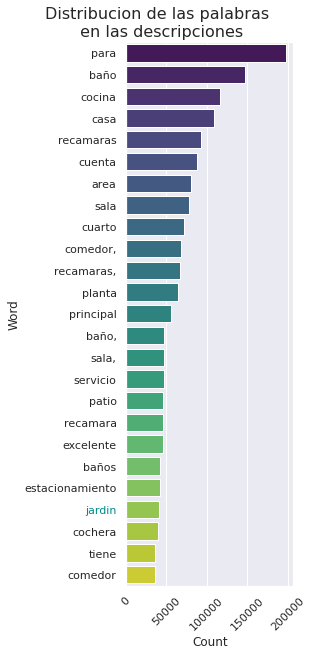

In [8]:
# Ploteamos los resultados
plt.figure(figsize=(3, 10))
df = pd.DataFrame(new_list, columns = ['Word', 'Count'])
sns.set()
barplot = sns.barplot(data=df, x='Count',y='Word', palette="viridis")
barplot.get_yticklabels()[21].set_color("darkcyan")
plt.xticks(rotation=45)
barplot.set_title('Distribucion de las palabras \n en las descripciones', fontdict={'fontsize':16}, x=0.2)
plt.savefig("Exp3/Distribucion-de-las-palabras-en-las-descripciones.png", bbox_inches = "tight")
plt.show()

Veamos en que puesto quedaron otras palabras del dataset

In [9]:
words_in_most_common = []
i=0
for word in most_occur:
    for fam_word in dicc_family:
        if word[0] == fam_word:
            words_in_most_common.append((word[0],word[1],i))
            break;
    i+=1
print(words_in_most_common)

[('jardin', 41103, 45), ('amplia', 25506, 73), ('vigilancia', 25147, 75), ('amplio', 19312, 95), ('estudio', 13006, 131), ('seguridad', 12782, 136), ('plaza', 10491, 171), ('parque', 7875, 223), ('cancha', 5395, 323), ('family', 3904, 437), ('tranquila', 3620, 467), ('familia', 2479, 642), ('hospital', 1803, 854), ('iluminado', 1740, 882), ('familiar', 1538, 975), ('seguro', 1496, 991), ('segura', 1401, 1036), ('niños', 1338, 1075), ('escuela', 863, 1479), ('alfombra', 580, 2032), ('juego', 460, 2406), ('infantil', 332, 3095), ('recreacion', 241, 3881), ('pareja', 177, 4794), ('madre', 143, 5571), ('guardia', 128, 5994), ('policia', 108, 6747), ('niño', 104, 6938), ('alfombrada', 89, 7618), ('guarderia', 84, 7872), ('padre', 27, 16480), ('niñas', 25, 17085), ('suave', 18, 21306), ('school', 10, 31247), ('bebe', 6, 41534), ('abuela', 1, 410723)]


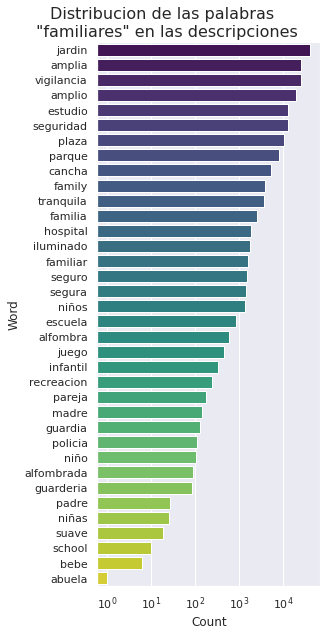

In [10]:
import matplotlib
# Ploteamos los resultados
plt.figure(figsize=(4, 10))
df_2 = pd.DataFrame(words_in_most_common, columns = ['Word', 'Count', "Position"])
sns.set()
barplot = sns.barplot(data=df_2, x='Count',y='Word', palette="viridis")
#plt.xticks(rotation=45)
barplot.set_xscale('log')
barplot.set_title('Distribucion de las palabras \n "familiares" en las descripciones', fontdict={'fontsize':16}, x=0.3)
plt.savefig("Exp3/Distribucion-de-las-palabras-del-dicc-family-en-las-descripciones.png", bbox_inches = "tight")
plt.show()

Por ultimo agrego la columna nueva al dataset

In [11]:
#Creo la nueva columna en el dataset
df_train_new = df_train
df_train_new["apto_familia"]=family_list
display(df_train_new.head(2))

,id,titulo,descripcion,tipodepropiedad,direccion,ciudad,provincia,antiguedad,habitaciones,garages,banos,metroscubiertos,metrostotales,idzona,lat,lng,fecha,gimnasio,usosmultiples,piscina,escuelascercanas,centroscomercialescercanos,precio,apto_familia
0,254099,depto. tipo a-402,"depto. interior de 80.15m2, consta de sala com...",Apartamento,Avenida Division del Norte 2005,Benito Juárez,Distrito Federal,NaN,2.0,1.0,2.0,80.0,80.0,23533.0,NaN,NaN,2015-08-23 00:00:00,0.0,0.0,0.0,0.0,0.0,2273000.0,0
1,53461,condominio horizontal en venta,"<p>entre sonora y guerrero, atr&aacute;s del h...",Casa en condominio,AV. MEXICO,La Magdalena Contreras,Distrito Federal,10.0,3.0,2.0,2.0,268.0,180.0,24514.0,19.310205,-99.227655,2013-06-28 00:00:00,0.0,0.0,0.0,1.0,1.0,3600000.0,1


In [12]:
# Limpio los valores que tienen NaN en "habitaciones" y "baños"
display(df_train_new.shape)
df_train_new = df_train_new[df_train_new['habitaciones'].notna()]
df_train_new = df_train_new[df_train_new['banos'].notna()]
df_train_new = df_train_new[df_train_new['metroscubiertos'].notna()]
display(df_train_new.shape)

(240000, 24)

(202956, 24)

Ya tengo listo el nuevo dataset, por lo que procedo a prepara el fitting

Vamos a separar el analisis para comparar si el fitting es mejor si particiono los resultados en casas y dptos

Por lo que primero debemos hacer la particion


## Arreglos para realizar el particionamiento en Casas y Departamentos

In [13]:
# Veo los tipos de propiedad del dataset
print(df_train_new.tipodepropiedad.value_counts())

Casa                             127228
Apartamento                       54955
Casa en condominio                17936
Casa uso de suelo                   386
Terreno                             385
Duplex                              331
Quinta Vacacional                   321
Villa                               280
Local Comercial                     228
Oficina comercial                   215
Departamento Compartido             132
Rancho                              128
Bodega comercial                    119
Edificio                            109
Terreno comercial                    59
Inmuebles productivos urbanos        52
Otros                                50
Nave industrial                      11
Local en centro comercial             8
Huerta                                7
Terreno industrial                    3
Name: tipodepropiedad, dtype: int64


Primero vamos a limpiar los outliers de "metroscubiertos" para obtener mejores resultados

In [14]:
from extra_scripts import remove_outliers
df_train_new = remove_outliers(df_train_new, "metroscubiertos", 2)

(192769, 24)


Ahora vamos a separar en dos datasets en base a los tipos:
- Casa: "Casa", "Casa en condominio", "Casa uso de suelo"
- Departamento: "Apartamento", "Departamento Compartido", "Edificio"

In [15]:
# Nuevo dataframe para tipo:casa
df_train_casa = df_train_new[(df_train_new["tipodepropiedad"]=="Casa") | (df_train_new["tipodepropiedad"]=="Casa en condominio") | (df_train_new["tipodepropiedad"]=="Casa uso de suelo")]
display(df_train_casa.tipodepropiedad.value_counts())

# Nuevo dataframe para tipo:dpto
df_train_dpto = df_train_new[(df_train_new["tipodepropiedad"]=="Apartamento") | (df_train_new["tipodepropiedad"]=="Departamento Compartido") | (df_train_new["tipodepropiedad"]=="Edificio")]
display(df_train_dpto.tipodepropiedad.value_counts())


Casa                  118692
Casa en condominio     16970
Casa uso de suelo        321
Name: tipodepropiedad, dtype: int64

Apartamento                54553
Departamento Compartido      129
Edificio                      88
Name: tipodepropiedad, dtype: int64

## Fitting

Antes de hacer el fitting veo que tan bien esta correlacionada la nueva feature y elegimos otras dos para poder hacer una buena estimacion

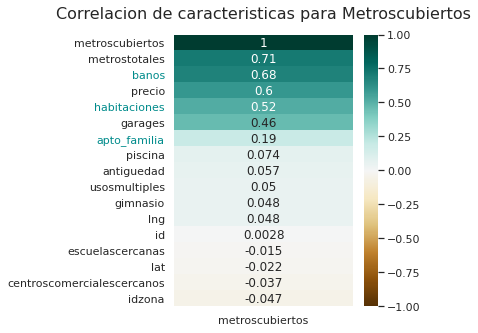

In [16]:
plt.figure(figsize=(4, 5))
heatmap = sns.heatmap(df_train_new.corr()[['metroscubiertos']].sort_values(by='metroscubiertos', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlacion de caracteristicas para Metroscubiertos', fontdict={'fontsize':16}, pad=16)

heatmap.get_yticklabels()[2].set_color("darkcyan")
heatmap.get_yticklabels()[4].set_color("darkcyan")
heatmap.get_yticklabels()[6].set_color("darkcyan")
plt.savefig("Exp3/Correlacion-de-caracteristicas-para-Metroscubiertos.png", bbox_inches = "tight")

Elegimos las features "habitaciones" y "banos" junto a "apto_familia" para estimar los metroscubiertos

Ahora si ya estamos listos para hacer entrenar al modelo

Por un lado puedo hacer directamente el fitting de las dos nuevas particiones
Pero debo proceder de otra forma (en cuanto al codigo) para evaluar el fitting sin particionamiento

In [17]:
# Reduzco el dataset de casa, para equiparar los tamaños con el dataset de dptos
df_train_casa = df_train_casa.sample(random_state=np.random.seed(1), frac=1)
df_train_casa = df_train_casa[:60000]
x_train = df_train_casa[["habitaciones", "apto_familia", "banos"]].values
y_train = df_train_casa["metroscubiertos"].values

# Metricas del conjunto de training
results_casa_part = cross_validate(10, x_train, y_train, True, True)

RMSE = (59.245836427347264, 0.5408631010361746)
RMSLE = (0.3637793193228954, 0.0038469290989549755)
R2 = (0.4694805082144816, 0.011818281877131779)


In [18]:
x_train = df_train_dpto[["habitaciones", "apto_familia", "banos"]].values
y_train = df_train_dpto["metroscubiertos"].values

# Metricas del conjunto de training
results_dpto_part = cross_validate(10, x_train, y_train, True, True)

RMSE = (41.8593286722581, 0.6218339980057499)
RMSLE = (0.3164496581569502, 0.0022554229833720895)
R2 = (0.5524487019240183, 0.007123874559336908)


Ahora vamos al caso de filtrar los resultados sin particionamiento, para ello haremos una modificacion del metodo **cross_validate**

In [19]:
# Importo las funciones necesarias
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

from extra_scripts import rmse, rmsle

def cross_validate_mod(K, X, Y, tipos, visualize = False, R2 = False):
    """
    Funcion custom para el TP 
    """
    def display_metrics(dict_k):
        """
        Funcion que permite visualizar la data
        """
        rmse, rmsle, r2= dict_k["RMSE"], dict_k["RMSLE"], dict_k["R2"]

        print(f"RMSE = {(np.mean(rmse), np.std(rmse))}")
        print(f"RMSLE = {(np.mean(rmsle), np.std(rmsle))}")
        if R2 == True:
            print(f"R2 = {(np.mean(r2), np.std(r2))}")

    # Usamos la funcion de skleanr para generar los splits 
    kfold = KFold(n_splits=K)
    kfold.get_n_splits(X)
    splits = kfold.split(X)

    #Almacenamos las metricas en arrays
    # MODIFICACION: guardamos 2 juegos de arrays, para casa o dpto
    casa_rmse_values = []
    casa_rmsle_values = []
    casa_R2_values = []
    dpto_rmse_values = []
    dpto_rmsle_values = []
    dpto_R2_values = []
    
    for index_train, index_test in splits:
        # Tomamos el split correspondiente
        X_train, X_test = X[index_train], X[index_test]
        Y_train, Y_test = Y[index_train], Y[index_test]
        # MODIFICACION:
        split_tipos = tipos[index_test]

        # Se calcula la prediccion
        regression = metnum.LinearRegression()
        regression.fit(X_train, Y_train)
        y_pred = regression.predict(X_test)        
        
        # Se evaluan las metricas
        # MODIFICACION:
        # Vamos a separar los resultados de casa o dptos para tomar las metricas
        Y_test_casa, Y_test_dpto = [], []
        y_pred_casa, y_pred_dpto = [], []
        for i in range(len(Y_test)):
            if (split_tipos[i]=="Casa") | (split_tipos[i]=="Casa en condominio") | (split_tipos[i]=="Casa uso de suelo"):
                Y_test_casa.append(Y_test[i])
                y_pred_casa.append(y_pred[i])
            else:
                Y_test_dpto.append(Y_test[i])
                y_pred_dpto.append(y_pred[i])
        
        Y_test_casa = np.asarray(Y_test_casa)
        Y_test_dpto = np.asarray(Y_test_dpto)
        y_pred_casa = np.asarray(y_pred_casa)
        y_pred_dpto = np.asarray(y_pred_dpto)

        # CASA:
        if Y_test_casa.shape[0] != 0:
            casa_R2_values.append(r2_score(Y_test_casa, y_pred_casa))
            if np.any(y_pred_casa < 0):
                print("Error! Se obtuvo un negativo, se procede a tomar el valor absoluto")
                y_pred_casa = np.abs(y_pred_casa)
            casa_rmse_values.append(rmse(Y_test_casa, y_pred_casa))
            casa_rmsle_values.append(rmsle(Y_test_casa, y_pred_casa))

        # DPTO:
        if Y_test_dpto.shape[0] != 0:
            dpto_R2_values.append(r2_score(Y_test_dpto, y_pred_dpto))
            if np.any(y_pred_dpto < 0):
                print("Error! Se obtuvo un negativo, se procede a tomar el valor absoluto")
                y_pred_dpto = np.abs(y_pred_dpto)
            dpto_rmse_values.append(rmse(Y_test_dpto, y_pred_dpto))
            dpto_rmsle_values.append(rmsle(Y_test_dpto, y_pred_dpto))

    #Los guardamos en un dict de numpy arrays
    #MODIFICACION:
    casa_metrics_dict = {"RMSE": np.asarray(casa_rmse_values),
                         "RMSLE": np.asarray(casa_rmsle_values),
                         "R2": np.asarray(casa_R2_values)}

    dpto_metrics_dict = {"RMSE": np.asarray(dpto_rmse_values),
                         "RMSLE": np.asarray(dpto_rmsle_values),
                         "R2": np.asarray(dpto_R2_values)}

    if(visualize):
        display_metrics(casa_metrics_dict)
        display_metrics(dpto_metrics_dict)

    return (casa_metrics_dict, dpto_metrics_dict)

In [20]:
df_train_concat = pd.concat([df_train_casa, df_train_dpto])
x_train = df_train_concat[["habitaciones", "apto_familia", "banos"]].values
y_train = df_train_concat["metroscubiertos"].values

tipos = df_train_concat["tipodepropiedad"].values

# Metricas del conjunto de training
results_without_part = cross_validate_mod(10, x_train, y_train, tipos, True, True)

RMSE = (60.85531351400894, 0.858074317340719)
RMSLE = (0.3549361318073994, 0.003283222097285435)
R2 = (0.44108668124822753, 0.01696247044489868)
RMSE = (46.029594565958355, 0.2786483690780039)
RMSLE = (0.38614144608165785, 0.001713036743148157)
R2 = (0.45846182209799763, 0.004446083120822734)


## Analicemos los resultados

In [21]:
#CASA con particion
df_casa_part = pd.DataFrame.from_dict(results_casa_part)

#CASA sin particion
df_casa_wo_part = pd.DataFrame.from_dict(results_without_part[0])

#DPTO con particion
df_dpto_part = pd.DataFrame.from_dict(results_dpto_part)

#DPTO sin particion
df_dpto_wo_part = pd.DataFrame.from_dict(results_without_part[1])


In [22]:
# RMSE
# Dataframe para solo Casa
df_casa = pd.DataFrame(df_casa_part["RMSE"])
df_casa.columns = ["error"]
df_casa["clase"] = ["segmentado"]*df_casa.shape[0]

df_casa_aux = pd.DataFrame(df_casa_wo_part["RMSE"])
df_casa_aux.columns = ["error"]
df_casa_aux["clase"] = ["no segmentado"]*df_casa_aux.shape[0]

df_casa = pd.concat([df_casa, df_casa_aux])
df_casa["tipo"] = ["casa"]*df_casa.shape[0]

# Dataframe para solo Dpto
df_dpto = pd.DataFrame(df_dpto_part["RMSE"])
df_dpto.columns = ["error"]
df_dpto["clase"] = ["segmentado"]*df_dpto.shape[0]

df_dpto_aux = pd.DataFrame(df_dpto_wo_part["RMSE"])
df_dpto_aux.columns = ["error"]
df_dpto_aux["clase"] = ["no segmentado"]*df_dpto_aux.shape[0]

df_dpto = pd.concat([df_dpto, df_dpto_aux])
df_dpto["tipo"] = ["dpto"]*df_dpto.shape[0]

# Unimos los dataframes de RMSE
df_rmse = pd.concat([df_casa, df_dpto])


In [23]:
# RMSLE
# Dataframe para solo Casa
df_casa = pd.DataFrame(df_casa_part["RMSLE"])
df_casa.columns = ["error"]
df_casa["clase"] = ["segmentado"]*df_casa.shape[0]

df_casa_aux = pd.DataFrame(df_casa_wo_part["RMSLE"])
df_casa_aux.columns = ["error"]
df_casa_aux["clase"] = ["no segmentado"]*df_casa_aux.shape[0]

df_casa = pd.concat([df_casa, df_casa_aux])
df_casa["tipo"] = ["casa"]*df_casa.shape[0]

# Dataframe para solo Dpto
df_dpto = pd.DataFrame(df_dpto_part["RMSLE"])
df_dpto.columns = ["error"]
df_dpto["clase"] = ["segmentado"]*df_dpto.shape[0]

df_dpto_aux = pd.DataFrame(df_dpto_wo_part["RMSLE"])
df_dpto_aux.columns = ["error"]
df_dpto_aux["clase"] = ["no segmentado"]*df_dpto_aux.shape[0]

df_dpto = pd.concat([df_dpto, df_dpto_aux])
df_dpto["tipo"] = ["dpto"]*df_dpto.shape[0]

# Unimos los dataframes de RMSLE
df_rmsle = pd.concat([df_casa, df_dpto])


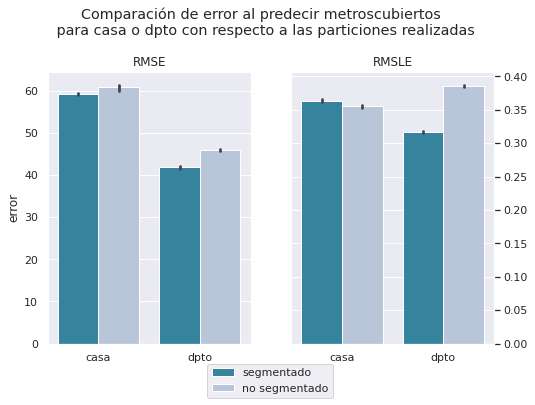

In [24]:
sns.set()
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(8, 5), sharey=False)
sns.barplot(ax=ax1, data=df_rmse, y='error', x="tipo", hue="clase", palette="PuBuGn_r")
sns.barplot(ax=ax2, data=df_rmsle, y='error', x="tipo", hue="clase", palette="PuBuGn_r")

ax1.get_legend().remove()
ax2.legend(bbox_to_anchor=(0.63,0.085), loc="lower", bbox_transform=fig.transFigure)
x_axis = ax1.xaxis.label.set_visible(False)
ax1.set_title("RMSE")

ax2.yaxis.tick_right()
y_axis = ax2.yaxis.label.set_visible(False)
x_axis = ax2.xaxis.label.set_visible(False)
ax2.set_title("RMSLE")

fig.suptitle("Comparación de error al predecir metroscubiertos \n para casa o dpto con respecto a las particiones realizadas", y=1.06)
plt.savefig("Exp3/Comp-de-error-con-y-sin-particion.png", bbox_inches = "tight")

In [25]:
# R2
# Dataframe para solo Casa
df_casa = pd.DataFrame(df_casa_part["R2"])
df_casa.columns = ["value"]
df_casa["clase"] = ["segmentado"]*df_casa.shape[0]

df_casa_aux = pd.DataFrame(df_casa_wo_part["R2"])
df_casa_aux.columns = ["value"]
df_casa_aux["clase"] = ["no segmentado"]*df_casa_aux.shape[0]

df_casa = pd.concat([df_casa, df_casa_aux])
df_casa["tipo"] = ["casa"]*df_casa.shape[0]

# Dataframe para solo Dpto
df_dpto = pd.DataFrame(df_dpto_part["R2"])
df_dpto.columns = ["value"]
df_dpto["clase"] = ["segmentado"]*df_dpto.shape[0]

df_dpto_aux = pd.DataFrame(df_dpto_wo_part["R2"])
df_dpto_aux.columns = ["value"]
df_dpto_aux["clase"] = ["no segmentado"]*df_dpto_aux.shape[0]

df_dpto = pd.concat([df_dpto, df_dpto_aux])
df_dpto["tipo"] = ["dpto"]*df_dpto.shape[0]

# Unimos los dataframes de RMSLE
df_r2 = pd.concat([df_casa, df_dpto])

<Figure size 432x288 with 0 Axes>

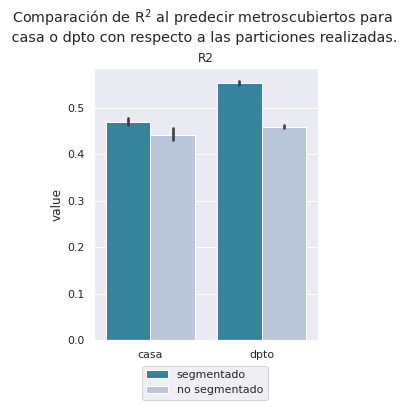

In [51]:
fig = plt.figure(constrained_layout=True)
fig, ax = plt.subplots(figsize=(4, 5))
sns.barplot(ax=ax, data=df_r2, y='value', x="tipo", hue="clase", palette="PuBuGn_r")
ax.legend(bbox_to_anchor=(0.27,0.07), loc="upper left",  bbox_transform=fig.transFigure)
x_axis = ax.xaxis.label.set_visible(False)
ax.set_title("R2")
fig.suptitle(r"Comparación de $\mathrm{R}^2$ al predecir metroscubiertos para" + f"\n casa o dpto con respecto a las particiones realizadas.", y=1.05)
plt.savefig("Exp3/Comp-de-R2-con-y-sin-particion.png", bbox_inches = "tight")